###### Applications of MachineLearning Assignment : 2022-2023
Mission: Save the Beavers
Terrain Identification using Artificial Intelligence
(Simple CNN or Masked R-CNN)

**Team:** 


Swanand Pravin Chawathe (2121373)
Student,
Anglia Ruskin University,
Cambridge, United Kingdom

Rahaf Saffaf (2178425)
Student,
Anglia Ruskin University,
Cambridge, United Kingdom


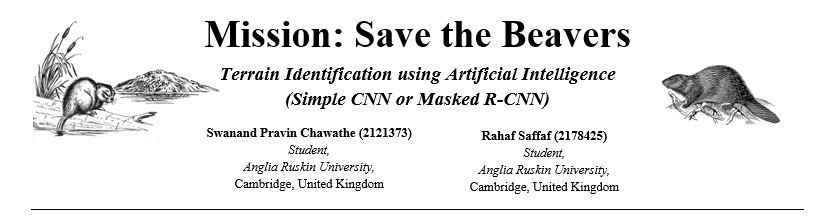

On our Mission to save the Beavers we will be working through various techniques and CNN models to eventually find interesting results and learn and acknowledge of the Applications of Machine learning in real world, in our case a nobel cause to save the Beavers.







## EXPERIMENT I
#### (Simple CNN )

We start our experiment by Using Simple Convolution Neural Network to check on its effective in our mission to save the Beavers, that is to successfully identify the terrains and Beaver Dams and Lodges. 

We will be using the annotations/masks created by label Box as source, however we will process the images and masks further to make it suitable for Simple CNN by reducing the number of labels.

**Data Annotation: Labelling using Label Box:**

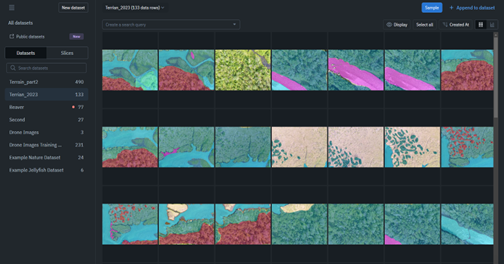

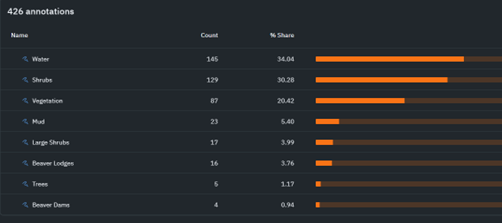

**Select the environment to run the code wither GPU or CPU**

In [ ]:
### Code to control the run of code on selective environments

RUN_ON="GPU"  
#RUN_ON="LOCAL"
# comment out either one
EPOCH=10 #default less EPOCHS to enable run on local machine

**If GPU then number of epochs to run**

In [ ]:
if RUN_ON=="GPU":
    EPOCH=500

**Import Libraries**

In [ ]:
#importing libraries
import sys
import numpy as np
import os
import pandas as pd
import json
import urllib
from urllib import request
from tqdm import tqdm
import math
import cv2
import warnings 
warnings.filterwarnings('ignore') #to ignore warnings



In [ ]:
#disable scrolling of large graph
# below code is useful when you want to see results without a scroll

In [ ]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**DATA ANALYSIS**

**Folder Path**

In [ ]:
#Creating the folder paths of the images with the masks for training and validation
images_folder = "Beaver_data/dataset/images/train/"
masks_folder = "Beaver_data/dataset/masks/train/"


#Creating the folder paths to resize and store the images (Image Rescaling)
# As the Machine Learning models are memory intensive, they are efficinet if we use smaller images to process,
# also this enables us create more number of training data images essential to better train a model.


images_resized_folder = 'Beaver_data/resized_data/images/'
images_resized_folder_train = 'Beaver_data/resized_data/images/train/'

masks_resized_folder = 'Beaver_data/resized_data/masks/'
masks_resized_folder_train = 'Beaver_data/resized_data/masks/train/'






In [ ]:
#defining a function in order to generate the images based on the paths defined above.
def generate_data_folders() -> None:
    """
    Generate two folders: one for the images and one for masks
    :return: None
    """
    print('### GENERATE FOLDERS ###')
    # Check if images folder exists
    if os.path.exists(images_folder):
        assert os.path.exists(images_folder)
        print('Images folder already exists!')
    else:
        print('Creating images folder')
        os.makedirs(images_folder)

    # Check if masks folder exists
    if os.path.exists(masks_folder):
        assert os.path.exists(masks_folder)
        print('Masks folder already exists')
    else:
        print('Creating masks folder')
        os.makedirs(masks_folder)

    # Check if images_resized folder exists
    if os.path.exists(images_resized_folder):
        assert os.path.exists(images_resized_folder)
        print('Images resized folder already exists')
    else:
        print('Creating resized images folders (train)')
        os.makedirs(images_resized_folder_train)

    # Check if masks_resized folder exists
    if os.path.exists(masks_resized_folder):
        assert os.path.exists(masks_resized_folder)
        print('Masks resized folder already exists')
    else:
        print('Creating resized masks folders (train)')
        os.makedirs(masks_resized_folder_train)
        




In [ ]:
generate_data_folders()

### GENERATE FOLDERS ###
Creating images folder
Creating masks folder
Creating resized images folders (train, val)
Creating resized masks folders (train, val)


**Load Images and Masks from Label Box using Json**
Label box provides an export functionality that generates a json that can be used to directly access the Label box server remotely and downlaod the images and masks created. This is better than uploading and downloading imags every time considering the size of images and count of images is high.

In [ ]:
# Dimensions of the images and masks download from LabelBox (these are our original drone images which are high definition)
WIDTH = 5472
HEIGHT = 3648

In [ ]:
#Defining a function in order to parse the json file to extract the images
def parse_json(json_path) -> (list, list):
    """
    Parse LabelBox JSON file to get the images URL and masks values and URL
    :param json_path: path to the json file
    :return:
        images_url: list of images URL
        masks_parameters: list of masks URL and value
    """
    print('### PARSING LABELBOX JSON FILE ###')

    images_url = []
    masks_parameters = []

    with open(json_path) as f:
        data = f.read()
        json_data = json.loads(data)

        image_names = []

        for i in range(len(json_data)):
            image_name = json_data[i]['External ID']
            image_url = json_data[i]['Labeled Data']
            image_names.append(image_name)
            images_url.append(image_url)

        # Mapping each image id to a number
        id_dict = {image_names[i]: i for i in range(len(json_data))}

        for i in range(len(json_data)):
            if 'Label' in json_data[i]:
                if 'objects' in json_data[i]['Label']:
                    object_data = json_data[i]['Label']['objects']
                    for j in range(len(object_data)):
                        masks_parameters.append([id_dict[json_data[i]['External ID']],
                                                 object_data[j]['value'],
                                                 object_data[j]['instanceURI']])

    print('Parsing completed!')
    print()


    return images_url, masks_parameters

In [ ]:
json_images = parse_json('export-2023-03-31T14_30_22.106Z.json')
# please note this is the file name of the json that is extracted from the Label box.
# This file has to be loaded under the content folder of GCP or kept at the root level.
# if new set of labels are created, a new export from label has to be created and the new file is to be used


### PARSING LABELBOX JSON FILE ###
Parsing completed!



In [ ]:
#Defining function in order to download all images from labelbox
def download_images(images_path, images_url) -> None:
    """
    Download all RGB images from LabelBox
    :param images_path: Path to folder where images are stored
    :param images_url: List of images URLs
    :return: None
    """
    print('### DOWNLOADING RGB IMAGES ###')
    # Check if images have already been downloaded
    if len(os.listdir(images_path)) == 72:
        print('Images have already been downloaded!')
        print()

        return None

    for i in tqdm(range(len(images_url)), desc='Progress Bar'):
        filename = images_path + str(i) + '.jpg'
        urllib.request.urlretrieve(images_url[i], filename)

    print()


def download_masks(masks_path, masks_parameters) -> None:
    """
    Download all masks associated to each image
    :param masks_path: Path to folder where masks are stored
    :param masks_parameters: List of 3 params list (id, label, url)
    :return: None
    """
    print('### DOWNLOADING MASKS ###')
    # Check if masks have already been downloaded
    if len(os.listdir(masks_path)) == 490:
        print('Masks have already been downloaded!')
        print()

        return None

    for i in tqdm(range(len(masks_parameters)), desc='Progress Bar'):
        masks = masks_parameters[i]
        download_path = masks_path
        filename = download_path + str(masks[0]) + '-' + masks[1] + '-' + 'mask' + str(i) + '.jpg'
        urllib.request.urlretrieve(masks[2], filename)

    print()

In [ ]:
download_images(images_folder,json_images[0])

### DOWNLOADING RGB IMAGES ###


Progress Bar: 100%|██████████| 103/103 [00:42<00:00,  2.44it/s]

In [ ]:
download_masks(masks_folder,json_images[1])

### DOWNLOADING MASKS ###


Progress Bar: 100%|██████████| 428/428 [06:27<00:00,  1.10it/s]

#### Resizing the images (croping)
* As every single original image is huge, we can create smaller chunks from one 
single image.
* The code derives a vertical and horizontal count based on the required size on an image and using a loop runs horizontal and vertical. basically a kernel moving across the image and breaking the image into smaller chunks


Sample below: An original image broken down into 24 images.
This helps generate larger data set of smaller image sizes manageable by the model and GPU

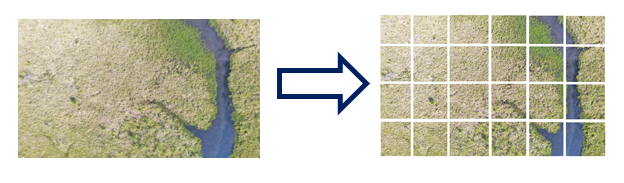

In [ ]:
#resizing the images, as every single original image is huge, we can create smaller chunks from one single image.
# the code derives a vertical and horizontal count derived based on the required size on an image and using a loop runs horizontal and vertical

def resize_files(src_path: str, dst_path: str, img_size: int) -> None:
    """
    Resize images or masks to the desired dimension
    :param src_path: source path
    :param dst_path: destination path
    :param img_size: size value in pixels (width, height have same value)
    :return: None
    """
    if src_path ==  images_folder or src_path ==  images_folder_val:
        print('### RESIZING IMAGES ###')
    else:
        print('### RESIZING MASKS ###')

    horizontal_count = math.ceil((WIDTH / img_size))
    horizontal_steps = (WIDTH - img_size) / horizontal_count

    vertical_count = math.ceil((HEIGHT / img_size))
    vertical_steps = (HEIGHT - img_size) / vertical_count

    for filename in tqdm(os.listdir(src_path), desc='Progress bar'):

        main_img = cv2.imread(os.path.join(src_path, filename))

        for i in range(vertical_count):
            if i < vertical_count - 1:
                y = round(i * vertical_steps)
            else:
                y = HEIGHT - img_size

            for j in range(horizontal_count):
                if j < horizontal_count - 1:
                    x = round(j * horizontal_steps)
                else:
                    x = WIDTH - img_size

                img = main_img[y:y + img_size, x:x + img_size]

                img_fname = '{}{}{}.jpg'.format(i, j, filename[:-4])
                cv2.imwrite(os.path.join(dst_path, img_fname), img)

    print()


In [ ]:
# Resize images train
resize_files(images_folder, images_resized_folder_train, 1024)
# Resize masks train
resize_files(masks_folder, masks_resized_folder_train, 1024)

# as we decide that we divide an image into 1024 by  1024 we end up creating alost 20 images out of a single image, thus the data set 
#will be resizsed to 20 times original

### RESIZING IMAGES ###


Progress bar: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]



### RESIZING MASKS ###


Progress bar: 100%|██████████| 428/428 [04:43<00:00,  1.51it/s]



### RESIZING IMAGES ###


Progress bar: 0it [00:00, ?it/s]



### RESIZING MASKS ###


Progress bar: 0it [00:00, ?it/s]

**Create MetaData**

To evaluate our outcome and to create a reduced label set with a single Label per image, the below code is written. we read the file names from the masks folder, as the file names have the image id and the mask name, reading the same helps us create a meta data which has all the labels created in Label box against a single image.

Further we added another column "Simply Beavers" that has a one to one mapping of one label against one image id. This label is set based on certain validations.
We check if "Beaver Dam" or "Beaver Lodge" or both are present in the file name, if none then we label it as "No Beaver Presence" 


**Important Observation and Consideration:**

>* As the Masks are also cropped for resizing, the mask folder might have images which are compeltely black, this works for Mask-RCNN however it would mean if we pick images which as which a no mask, yet file present in mask folder with Beaver dam or lodge, we are training the model with incorrect data. 
>* We observed this when we started creating metadata. Thus we carefully scrutinised the mask folder crated post resize, as the data size was small, we were able to identify the masks which has beaver dams and lodges manually using windows search function. Sample as below. 
>* The images with a white marking are the ones that actually have a Beaver presence and we can ignore the rest.
>* we made a note of useful image ids and used the ids in a list and picked only them. Rest were marked as "no beaver presence"



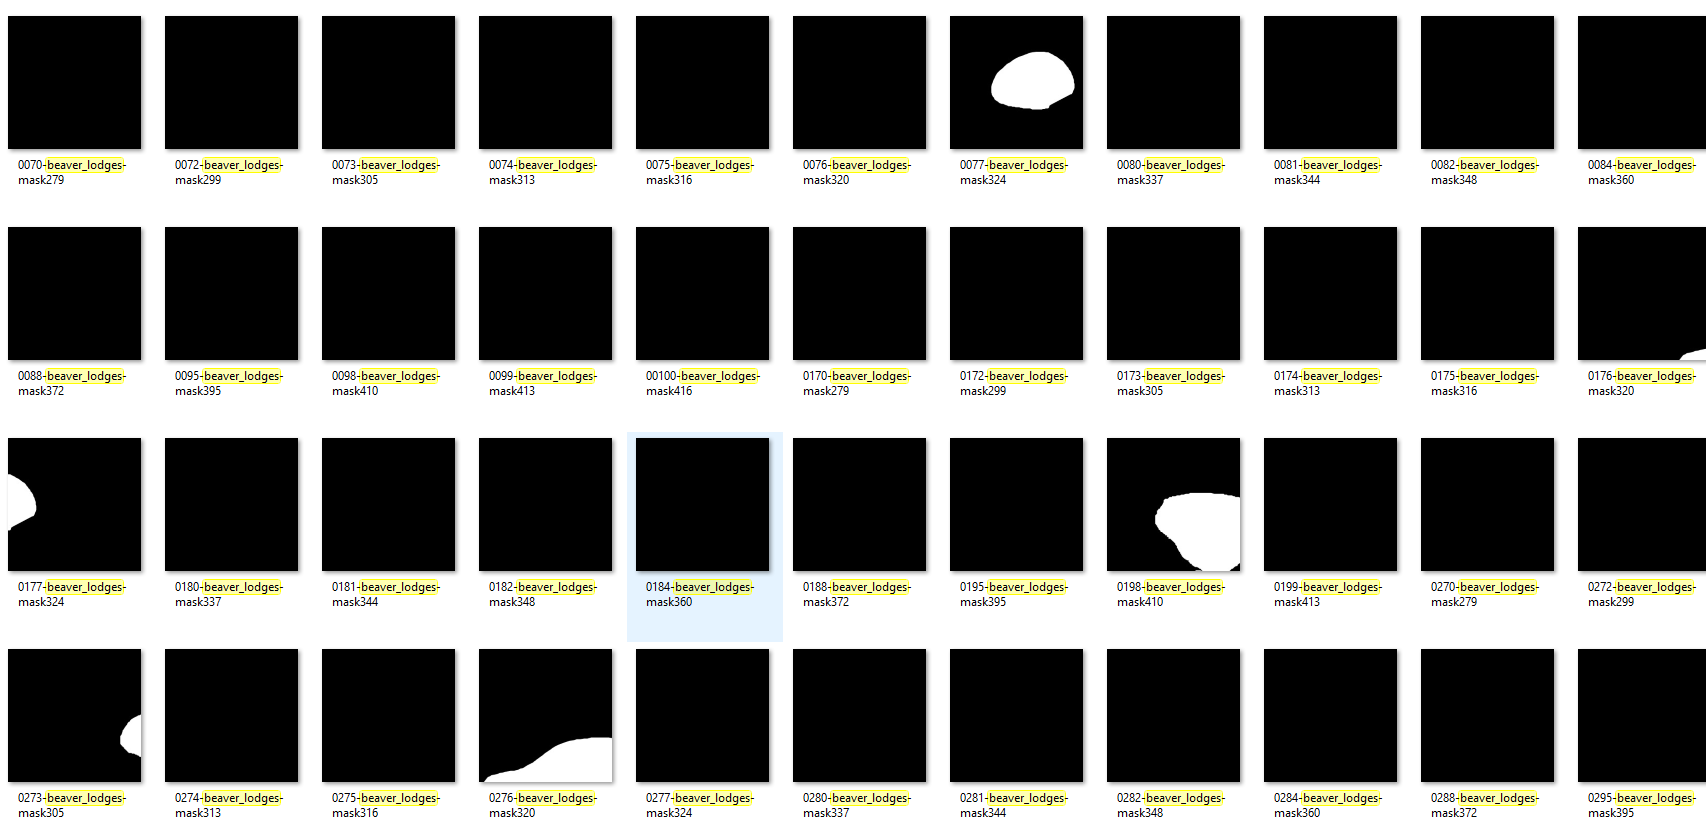

**Image Ids of the Images to be consider which have Beaver Presence:**

**Beaver Lodge:**
0077,0176,0177,0198,0273,0276,0298,0373,0376,0476,0588,1075,1077,1175,1176,1198,1273,1276,1298,1370,1373,1376,1476,1581,1588,2075,2175,2176,2199,2276,2280,2299,2370,2372,2376,2380,2395,2476,2480,2495,25812582,3074,3174,3199,3276,3299,3372,3376,3476,3584,31100,32100,

**Beaver_dams:**
0119, 0219, 0296, 1015, 1115, 1215, 1296, 1315, 1396, 2015,2115,2215,2297,2315,2397,

**Below Function helps crate Meta Data**

In [ ]:


path = '/content/Beaver_data/resized_data/masks/train/' # note we use the resized data as source here to increase the count of images
#path = 'C:\\Users\\Swanand\\Beaver_data\\resized_data\\masks\\train\\' local path for testing

#considering only masks that have Beaver Dams (as we had cropped a larger image, we have to carefully consider 
# only those cropped images that have a Beaver dam or lodge)
Bev_Dam=["0119","0219","0296","1015","1115","1215","1296","1315","1396","2015","2115","2215","2297","2315","2397"]
Bev_Lod=["0077","0176","0177","0198","0273","0276","0298","0373","0376","0476","0588","1075","1077","1175","1176","1198","1273","1276","1298","1370","1373","1376","1476","1581","1588","2075","2175","2176","2199","2276","2280","2299","2370","2372","2376","2380","2395","2476","2480","2495","25812582","3074","3174","3199","3276","3299","3372","3376","3476","3584","31100","32100"]
# Get the list of all files and directories and underdstand the class
def GetMetaData(path):
    
    File_List = os.listdir(path)
    count = len(File_List)

    #df_Meta_data= pd.DataFrame(columns = ['Image_ID','Class'], )
    #print (df_Meta_data)
    # prints all files
    df_MetaData= pd.DataFrame(columns = ['Image_ID','Class'])
    df_MetaData.info()
    for i in range(count):
        df_readFile= File_List[i].split('-')
        length = len(df_MetaData)
        values=[df_readFile[0], df_readFile[1]]
        df_MetaData.loc[length] = values 
    df_MetaData=df_MetaData.drop_duplicates(['Image_ID','Class']) # as single image can have multiple masks, we will remove the duplicates of this combination

    # to list all classes against a single image
    df_MetaData_grouped=df_MetaData.groupby(['Image_ID']).apply(lambda x: set(x.Class))

    df_MetaData_temp2= pd.DataFrame(columns = ['Image_ID','Class','Simply_Beavers'])
    i=0
    for item in df_MetaData_grouped: # loop to read from serial data and list get the data in data frames
        length = len(df_MetaData_temp2)
        if "beaver_dams" in item:
            if "beaver_lodges" in item:
             #   print (df_MetaData_grouped.index[i])
                values=[df_MetaData_grouped.index[i], item,'Beaver Dam and Lodge']
            else:
                if df_MetaData_grouped.index[i] in Bev_Dam:
                #  print (df_MetaData_grouped.index[i])
                  values=[df_MetaData_grouped.index[i], item,'Beaver Dam']
        else:
            if "beaver_lodges" in item:
                if df_MetaData_grouped.index[i] in Bev_Lod:
                 # print (df_MetaData_grouped.index[i])
                  values=[df_MetaData_grouped.index[i], item,'Beaver Lodge']
            else:
                 values=[df_MetaData_grouped.index[i], item,'No Beaver Presence']


   #     values=[df_MetaData_grouped.index[i], item  , 'bbb']
        df_MetaData_temp2.loc[length] = values 
        i=i+1
    return(df_MetaData_temp2)

In [ ]:
df_ResizedImage_Classes=GetMetaData(path)

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_ID  0 non-null      object
 1   Class     0 non-null      object
dtypes: object(2)
memory usage: 0.0+ bytes


In [ ]:
df_ResizedImage_Classes
# We can see that we have a single image id with multiple classes, as a simple or basic CNN wont have a way to identify multi class in a single image, 
# we create a new label "Simply_Beavers" which can help us identify whether a Beaver habitat is present or absent in an image.
# though not the best of approach, however it provides a good starting point to our experiment

Image_ID                               Class      Simply_Beavers
0         000         {vegetation, water, shrubs}  No Beaver Presence
1         001                     {water, shrubs}  No Beaver Presence
2        0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence
3        0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence
4       00101         {vegetation, water, shrubs}  No Beaver Presence
...       ...                                 ...                 ...
2443     3594         {vegetation, water, shrubs}  No Beaver Presence
2444     3594         {vegetation, water, shrubs}  No Beaver Presence
2445     3594         {vegetation, water, shrubs}  No Beaver Presence
2446     3594         {vegetation, water, shrubs}  No Beaver Presence
2447     3594         {vegetation, water, shrubs}  No Beaver Presence

[2448 rows x 3 columns]

**Data Analysis**

In [ ]:
#common function to display unique data and their count in a given dataset
import seaborn as sns
def getDistinctCount(dataset,columnname):
    print ("\033[1m Unique values of Column: " +columnname + "\033[0m")
    print (dataset[columnname].unique())
    print ("\033[1m Count of Unique values of Column: " +columnname +"\033[0m" )
    print ( dataset[columnname].value_counts())
    dataset[columnname].hist(alpha=1, figsize=(20, 10), bins=40, color = "green", edgecolor='k', );



 Unique values of Column: Simply_Beavers
['No Beaver Presence' 'Beaver Lodge' 'Beaver Dam']
 Count of Unique values of Column: Simply_Beavers
No Beaver Presence    2321
Beaver Lodge           104
Beaver Dam              23
Name: Simply_Beavers, dtype: int64


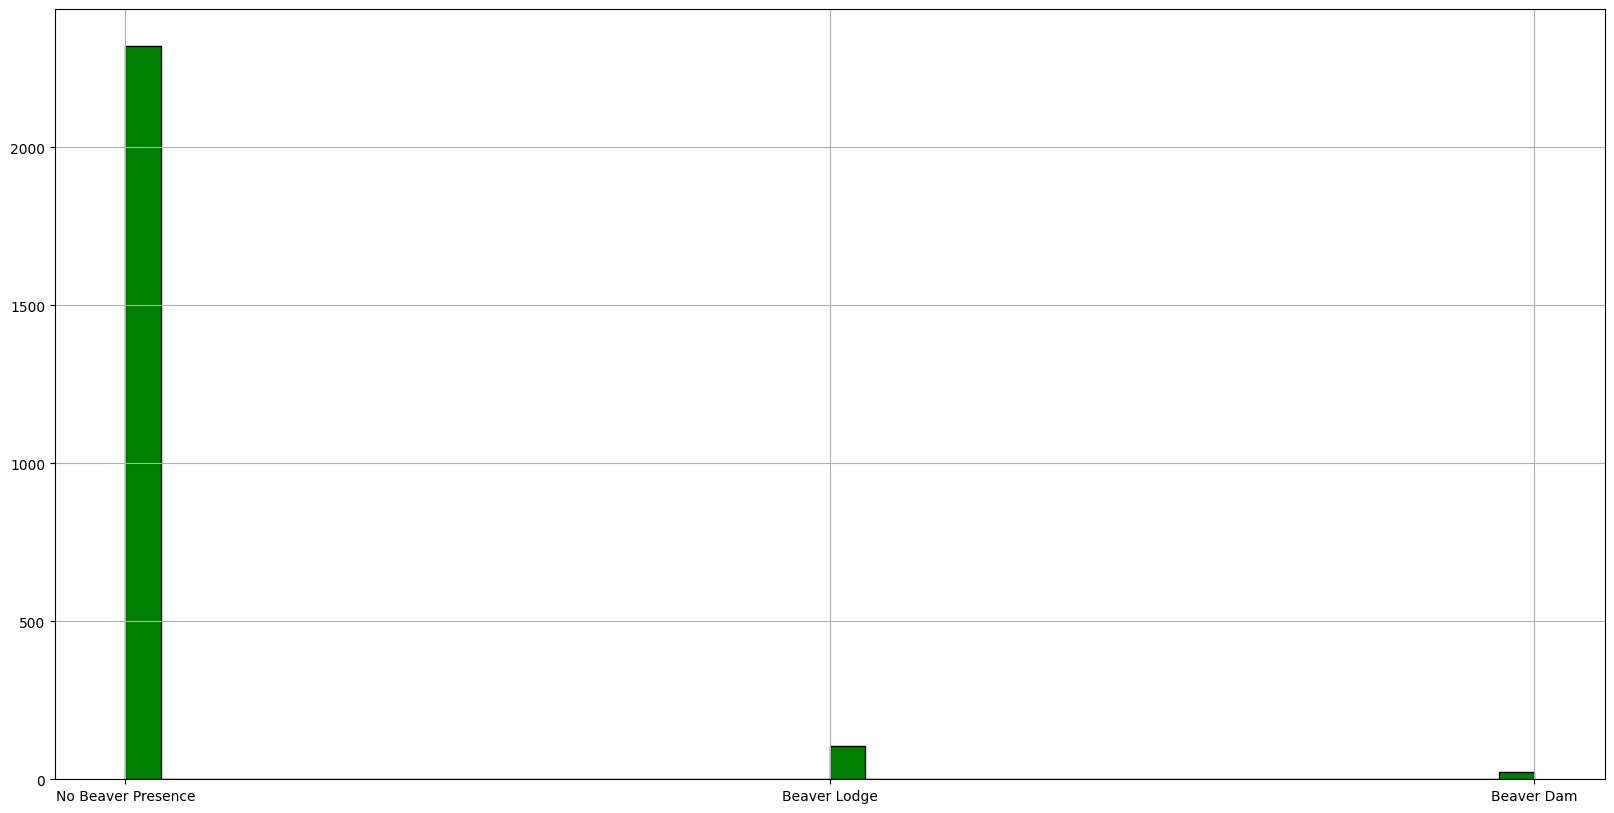

In [ ]:
getDistinctCount(df_ResizedImage_Classes, "Simply_Beavers")

**Observation:** It is observed that the data set is highly unbalanced with very low Beaver Lodge and Dam count, if the data is usd as is it will be highly biased towards "No Beaver Presence"

Statistics: (from above step)
* No Beaver Presence    2321
* Beaver Lodge           104
* Beaver Dam              23


**Processing Data:**
To solve the above problem, we generate images from the original to boost low count labels

##### Load iamges into dataframe

In [ ]:
df_ResizedImage_Classes

Image_ID                               Class      Simply_Beavers
0         000         {vegetation, water, shrubs}  No Beaver Presence
1         001                     {water, shrubs}  No Beaver Presence
2        0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence
3        0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence
4       00101         {vegetation, water, shrubs}  No Beaver Presence
...       ...                                 ...                 ...
2443     3594         {vegetation, water, shrubs}  No Beaver Presence
2444     3594         {vegetation, water, shrubs}  No Beaver Presence
2445     3594         {vegetation, water, shrubs}  No Beaver Presence
2446     3594         {vegetation, water, shrubs}  No Beaver Presence
2447     3594         {vegetation, water, shrubs}  No Beaver Presence

[2448 rows x 3 columns]

In [ ]:
# image path is created and updated in the data table to read the files by traveersing throught the table.
# Please note this path will chagne based on the environment and where the images are stored
df_ResizedImage_Classes["Image_Path"]='''/content/Beaver_data/resized_data/images/train/'''+df_ResizedImage_Classes["Image_ID"]+'.jpg'

#df_ResizedImage_Classes["Image_Path"]='''C:\\Users\\Swanand\\Beaver_data\\resized_data\\images\\train\\'''+df_ResizedImage_Classes["Image_ID"]+'.jpg' local path for testing


In [ ]:
df_ResizedImage_Classes

Image_ID                               Class      Simply_Beavers  \
0         000         {vegetation, water, shrubs}  No Beaver Presence   
1         001                     {water, shrubs}  No Beaver Presence   
2        0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence   
3        0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence   
4       00101         {vegetation, water, shrubs}  No Beaver Presence   
...       ...                                 ...                 ...   
2443     3594         {vegetation, water, shrubs}  No Beaver Presence   
2444     3594         {vegetation, water, shrubs}  No Beaver Presence   
2445     3594         {vegetation, water, shrubs}  No Beaver Presence   
2446     3594         {vegetation, water, shrubs}  No Beaver Presence   
2447     3594         {vegetation, water, shrubs}  No Beaver Presence   

                                             Image_Path  
0     /content/Beaver_data/resized_data/images/train...  
1     /content/Beaver_data/resized_data/images/train...  
2     /content/Beaver_data/resized_data/images/train...  
3     /content/Beaver_data/resized_data/images/train...  
4     /content/Beaver_data/resized_data/images/train...  
...                                                 ...  
2443  /content/Beaver_data/resized_data/images/train...  
2444  /content/Beaver_data/resized_data/images/train...  
2445  /content/Beaver_data/resized_data/images/train...  
2446  /content/Beaver_data/resized_data/images/train...  
2447  /content/Beaver_data/resized_data/images/train...  

[2448 rows x 4 columns]

In [ ]:
from PIL import Image

# loading the image from path in a  dataframe under "image" column
# Do note the images are resized further to a reduced 128 by 128 as the total image count stands at 2448
df_ResizedImage_Classes["Image"]=df_ResizedImage_Classes["Image_Path"].map(lambda i: np.asarray(Image.open(i).resize((128,128))))

In [ ]:
df_ResizedImage_Classes['Classification']=df_ResizedImage_Classes['Simply_Beavers'].map({'No Beaver Presence':0, 'Beaver Lodge':1, 'Beaver Dam':2 })
class_names = ['No Beaver Presence','Beaver Lodge','Beaver Dam']
#  mapping the class name to an numeric id under column Classification

In [ ]:
df_ResizedImage_Classes.head() # check to see if dataframe is loaded as expected

Image_ID                               Class      Simply_Beavers  \
0      000         {vegetation, water, shrubs}  No Beaver Presence   
1      001                     {water, shrubs}  No Beaver Presence   
2     0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence   
3     0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence   
4    00101         {vegetation, water, shrubs}  No Beaver Presence   

                                          Image_Path  \
0  /content/Beaver_data/resized_data/images/train...   
1  /content/Beaver_data/resized_data/images/train...   
2  /content/Beaver_data/resized_data/images/train...   
3  /content/Beaver_data/resized_data/images/train...   
4  /content/Beaver_data/resized_data/images/train...   

                                               Image  Classification  
0  [[[222, 213, 183], [221, 213, 178], [220, 211,...               0  
1  [[[231, 223, 189], [235, 225, 189], [237, 226,...               0  
2  [[[122, 113, 111], [117, 111, 111], [127, 123,...               0  
3  [[[122, 113, 111], [117, 111, 111], [127, 123,...               0  
4  [[[192, 199, 131], [224, 227, 176], [212, 218,...               0

###### Preview of loaded Images

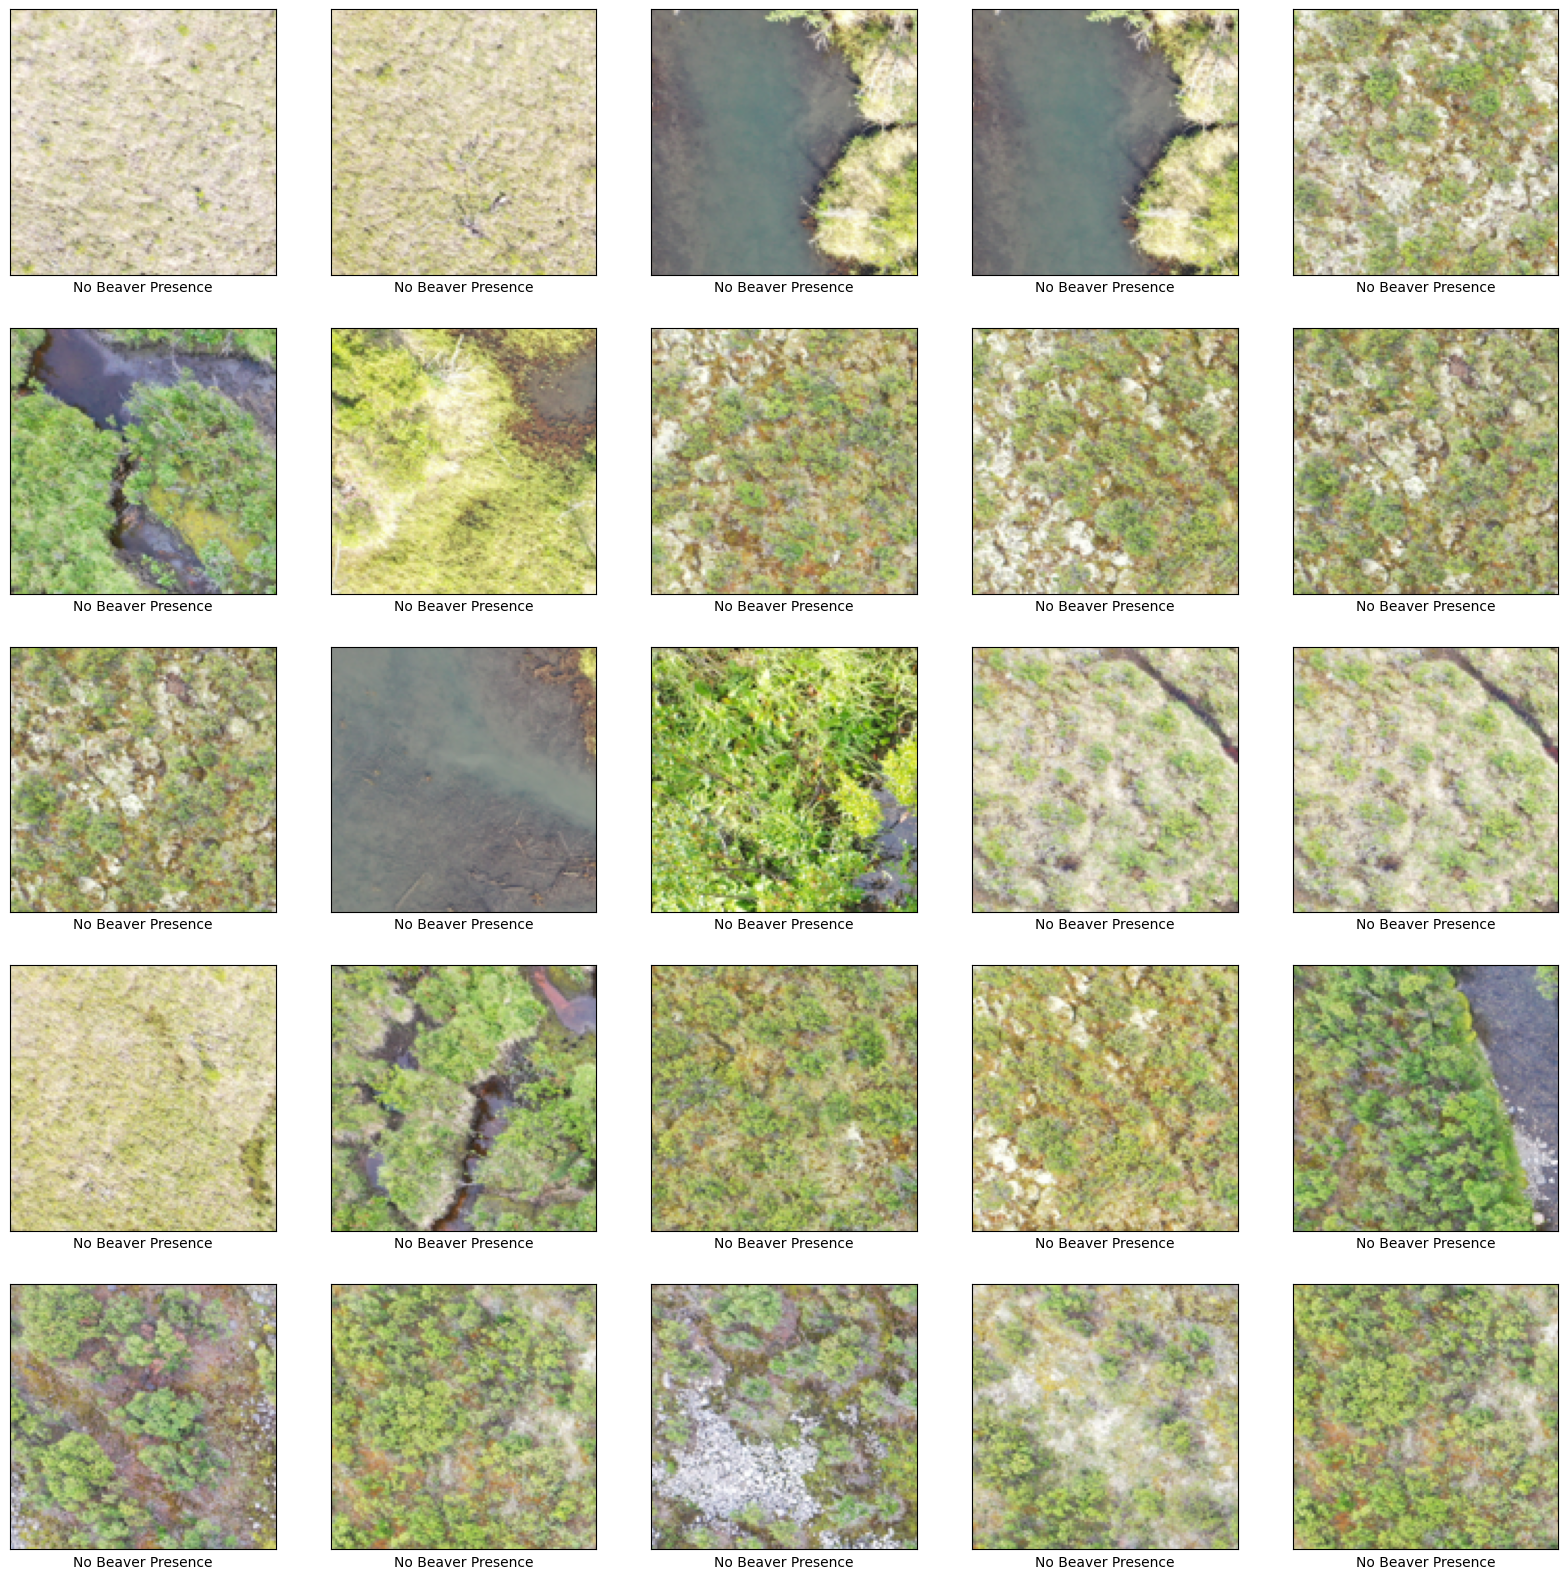

In [ ]:
# just to see the images loaded in a dataframe

import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df_ResizedImage_Classes["Image"][i])
    plt.xlabel(df_ResizedImage_Classes["Simply_Beavers"][i])
plt.show()

In [ ]:
# To Displaying one image of each class for reference, find unique index of "Simply_Beavers"
tmpDisplaydf=df_ResizedImage_Classes.Simply_Beavers.drop_duplicates()
tmpDisplaydf

0      No Beaver Presence
77           Beaver Lodge
116            Beaver Dam
Name: Simply_Beavers, dtype: object

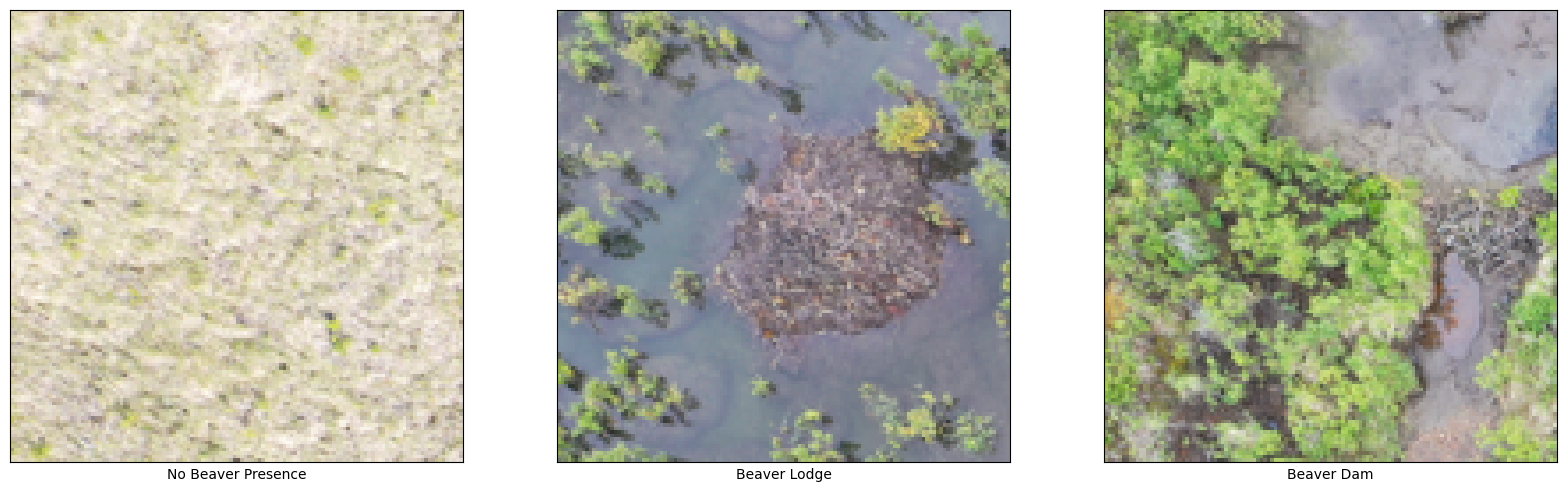

In [ ]:
# Displaying one image of each class for reference

plt.figure(figsize=(20,20))
i=0
for j in tmpDisplaydf.index:
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df_ResizedImage_Classes["Image"][j])
    plt.xlabel(df_ResizedImage_Classes["Simply_Beavers"][j])
    i = i+1
plt.show()

In [ ]:
# We can see from above the data is nicely loaded and we cna see a clear bifercation of three classes and we now see what actually
# beaver dams and lodges look like.

In [ ]:
# Increasing the Data Size:

**INCREASE DATA SIZE**

As we earlier observed that the data count of Beaver Lodge and dams are low, it is essential these counts are boosted, this is done by rotating the original image and storiing it as a new image for training. 
We rotate image by 90 degree, 180 degree, 270 degree i.e. 90 degree counter clock wise, the image will also be flipped vertically or horizontally

In [ ]:
# Creating a dataframe of all different augmented images for comparison
img_num=77
data = {'Image':  [(df_ResizedImage_Classes['Image'][img_num]), (cv2.rotate(df_ResizedImage_Classes['Image'][img_num], cv2.ROTATE_90_COUNTERCLOCKWISE)),(cv2.rotate(df_ResizedImage_Classes['Image'][img_num], cv2.ROTATE_90_CLOCKWISE)), (cv2.rotate(df_ResizedImage_Classes['Image'][img_num], cv2.ROTATE_180)),(cv2.flip(df_ResizedImage_Classes['Image'][img_num], 0)),(cv2.flip(df_ResizedImage_Classes['Image'][img_num], 1))],
        'Desc': ['Original', 'ROTATE_90_COUNTERCLOCKWISE', 'ROTATE_90_CLOCKWISE','ROTATE_180',  'FLIP VERTICAL','FLIP HORIZONTAL']}
dSampleImageGen = pd.DataFrame(data)

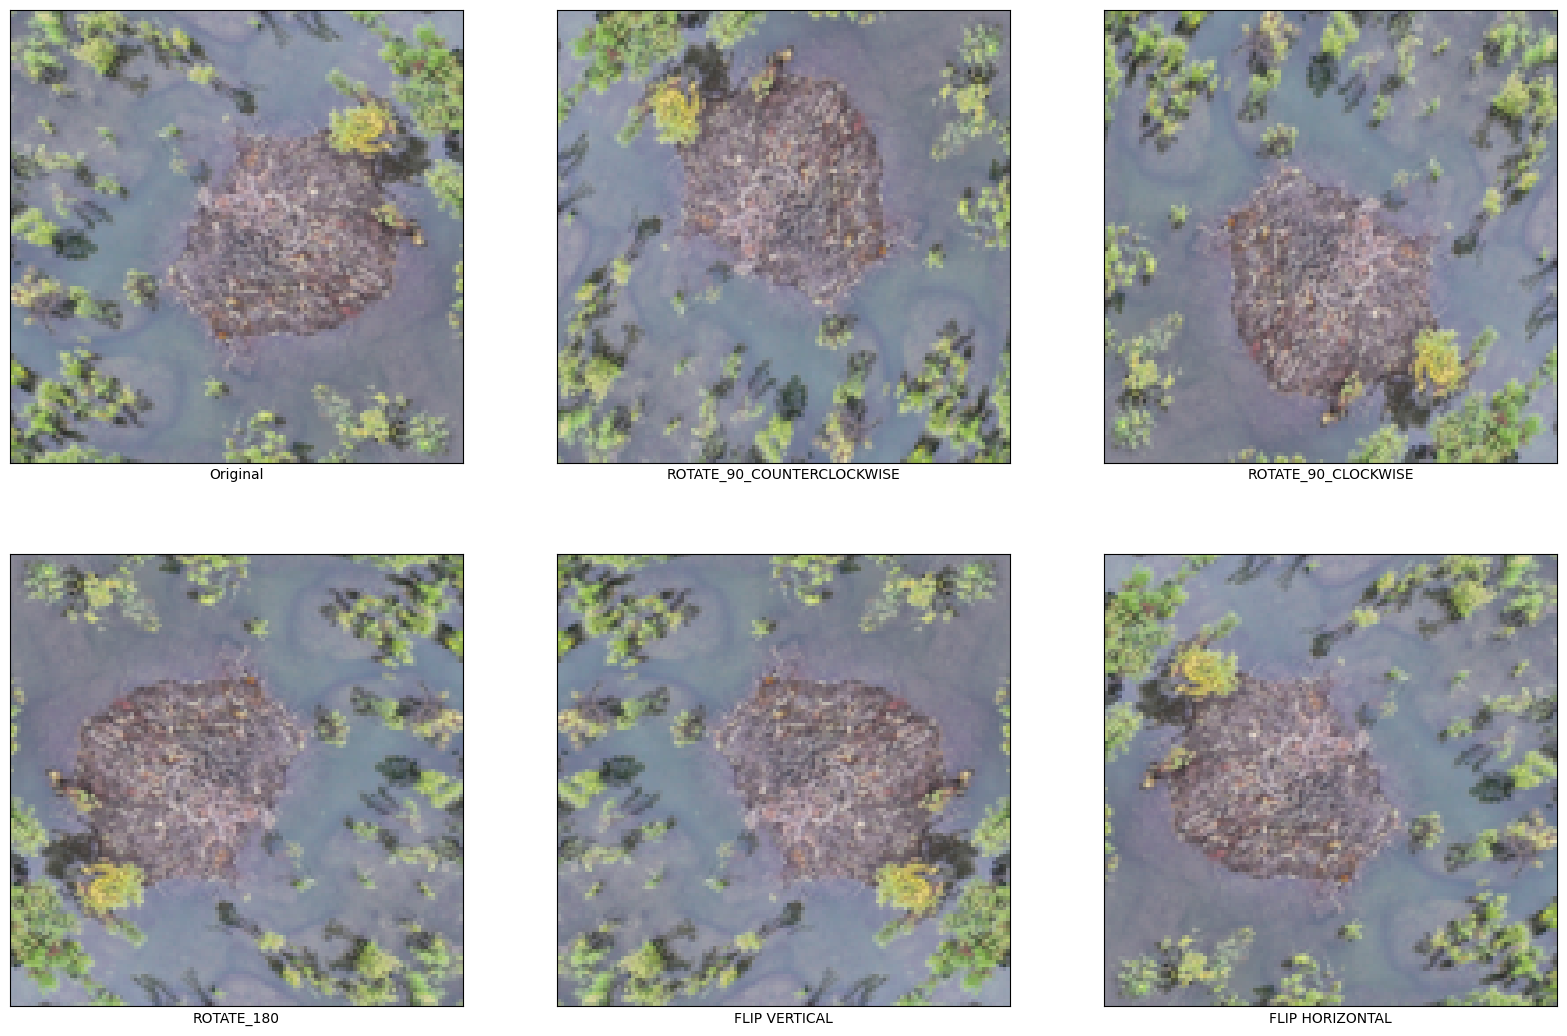

In [ ]:
# writing a loop to display original image and display images side by side

plt.figure(figsize=(20,20))
i=0
j=0


for j in range(dSampleImageGen.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dSampleImageGen['Image'][j])
    plt.xlabel(dSampleImageGen['Desc'][j])
    i = i+1

In [ ]:
# Writing a function to rotate an image
def ImageGen(Inp_Image, Action):
    if Action=="ROTATE_90_COUNTERCLOCKWISE":
        NewImage=(cv2.rotate(Inp_Image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    if Action=="ROTATE_90_CLOCKWISE":
        NewImage=(cv2.rotate(Inp_Image, cv2.ROTATE_90_CLOCKWISE))
    if Action=="ROTATE_180":
        NewImage=(cv2.rotate(Inp_Image, cv2.ROTATE_180))
    if Action=="FLIP VERTICAL":
        NewImage=(cv2.flip(Inp_Image, 1))
    if Action=="FLIP HORIZONTAL":
        NewImage=(cv2.flip(Inp_Image, 0))
    return NewImage

In [ ]:
dInpData_Expanded=df_ResizedImage_Classes.copy()
 #dInpData_Expanded has a expanded database including the resized and generated images

In [ ]:
dInpData_Expanded.head() 

Image_ID                               Class      Simply_Beavers  \
0      000         {vegetation, water, shrubs}  No Beaver Presence   
1      001                     {water, shrubs}  No Beaver Presence   
2     0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence   
3     0010  {large_shrubs, water, shrubs, mud}  No Beaver Presence   
4    00101         {vegetation, water, shrubs}  No Beaver Presence   

                                          Image_Path  \
0  /content/Beaver_data/resized_data/images/train...   
1  /content/Beaver_data/resized_data/images/train...   
2  /content/Beaver_data/resized_data/images/train...   
3  /content/Beaver_data/resized_data/images/train...   
4  /content/Beaver_data/resized_data/images/train...   

                                               Image  Classification  
0  [[[222, 213, 183], [221, 213, 178], [220, 211,...               0  
1  [[[231, 223, 189], [235, 225, 189], [237, 226,...               0  
2  [[[122, 113, 111], [117, 111, 111], [127, 123,...               0  
3  [[[122, 113, 111], [117, 111, 111], [127, 123,...               0  
4  [[[192, 199, 131], [224, 227, 176], [212, 218,...               0

In [ ]:
dInpData_Expanded.shape


(2448, 6)

In [ ]:
# Note: DATASET EXPANDED: Increase the image count of Beaver Dam and Beaver Lodge
# The target is to carefully generate images to ensure a better balance across the database.


# class_name  can be either "Beaver Dam" or "Beaver Lodge" , cnt id th number of times you wish to repeat the function
def Expand_Beaver_Count(cnt, class_name):
    for z in range(cnt):  # repeat the same steps to increase the data size further
        k=0
        for k in range(df_ResizedImage_Classes.shape[0]): # 5 times so 5 different ways of generation Rotate 90 degree clock and counter clock wise, 180 degree and flip vertical, flip horizontal
            if (df_ResizedImage_Classes["Simply_Beavers"][k]==class_name):
                length = len(dInpData_Expanded)
                values=[(df_ResizedImage_Classes["Image_ID"][k]+"_RCC90"),df_ResizedImage_Classes["Class"][k], df_ResizedImage_Classes["Simply_Beavers"][k],"NA",(ImageGen(df_ResizedImage_Classes["Image"][k],"ROTATE_90_COUNTERCLOCKWISE")), df_ResizedImage_Classes["Classification"][k]]
                dInpData_Expanded.loc[length] = values 
            if (df_ResizedImage_Classes["Simply_Beavers"][k]==class_name):
                length = len(dInpData_Expanded)
                values=[(df_ResizedImage_Classes["Image_ID"][k]+"_RC90"),df_ResizedImage_Classes["Class"][k], df_ResizedImage_Classes["Simply_Beavers"][k],"NA",(ImageGen(df_ResizedImage_Classes["Image"][k],"ROTATE_90_CLOCKWISE")), df_ResizedImage_Classes["Classification"][k]]
                dInpData_Expanded.loc[length] = values 
            if (df_ResizedImage_Classes["Simply_Beavers"][k]==class_name):
                length = len(dInpData_Expanded)
                values=[(df_ResizedImage_Classes["Image_ID"][k]+"_R180"),df_ResizedImage_Classes["Class"][k], df_ResizedImage_Classes["Simply_Beavers"][k],"NA",(ImageGen(df_ResizedImage_Classes["Image"][k],"ROTATE_180")), df_ResizedImage_Classes["Classification"][k]]
                dInpData_Expanded.loc[length] = values 
            if (df_ResizedImage_Classes["Simply_Beavers"][k]==class_name):
                length = len(dInpData_Expanded)
                values=[(df_ResizedImage_Classes["Image_ID"][k]+"_FV"),df_ResizedImage_Classes["Class"][k], df_ResizedImage_Classes["Simply_Beavers"][k],"NA",(ImageGen(df_ResizedImage_Classes["Image"][k],"FLIP VERTICAL")), df_ResizedImage_Classes["Classification"][k]]
                dInpData_Expanded.loc[length] = values 
            if (df_ResizedImage_Classes["Simply_Beavers"][k]==class_name):
                length = len(dInpData_Expanded)
                values=[(df_ResizedImage_Classes["Image_ID"][k]+"_FH"),df_ResizedImage_Classes["Class"][k], df_ResizedImage_Classes["Simply_Beavers"][k],"NA",(ImageGen(df_ResizedImage_Classes["Image"][k],"FLIP HORIZONTAL")), df_ResizedImage_Classes["Classification"][k]]
                dInpData_Expanded.loc[length] = values        

       


In [ ]:

#Class name             Original Count        Target Count
# No Beaver Presence    2321                  no action to be taken count already high
# Beaver Lodge          104                   should be doubled atleast 104 + 104*5*duplicate_count= 2184  (duplicate it by 4 times)
# Beaver Dam             23                   should be atleast 5 times of the current size 23+23*5*duplicate_count = 2208  (duplicat it by 19 times)

Expand_Beaver_Count(4, "Beaver Lodge")
Expand_Beaver_Count(19, "Beaver Dam")

In [ ]:
dInpData_Expanded.shape # new  dataset count 

(6713, 6)

 Unique values of Column: Simply_Beavers
['No Beaver Presence' 'Beaver Lodge' 'Beaver Dam']
 Count of Unique values of Column: Simply_Beavers
No Beaver Presence    2321
Beaver Dam            2208
Beaver Lodge          2184
Name: Simply_Beavers, dtype: int64


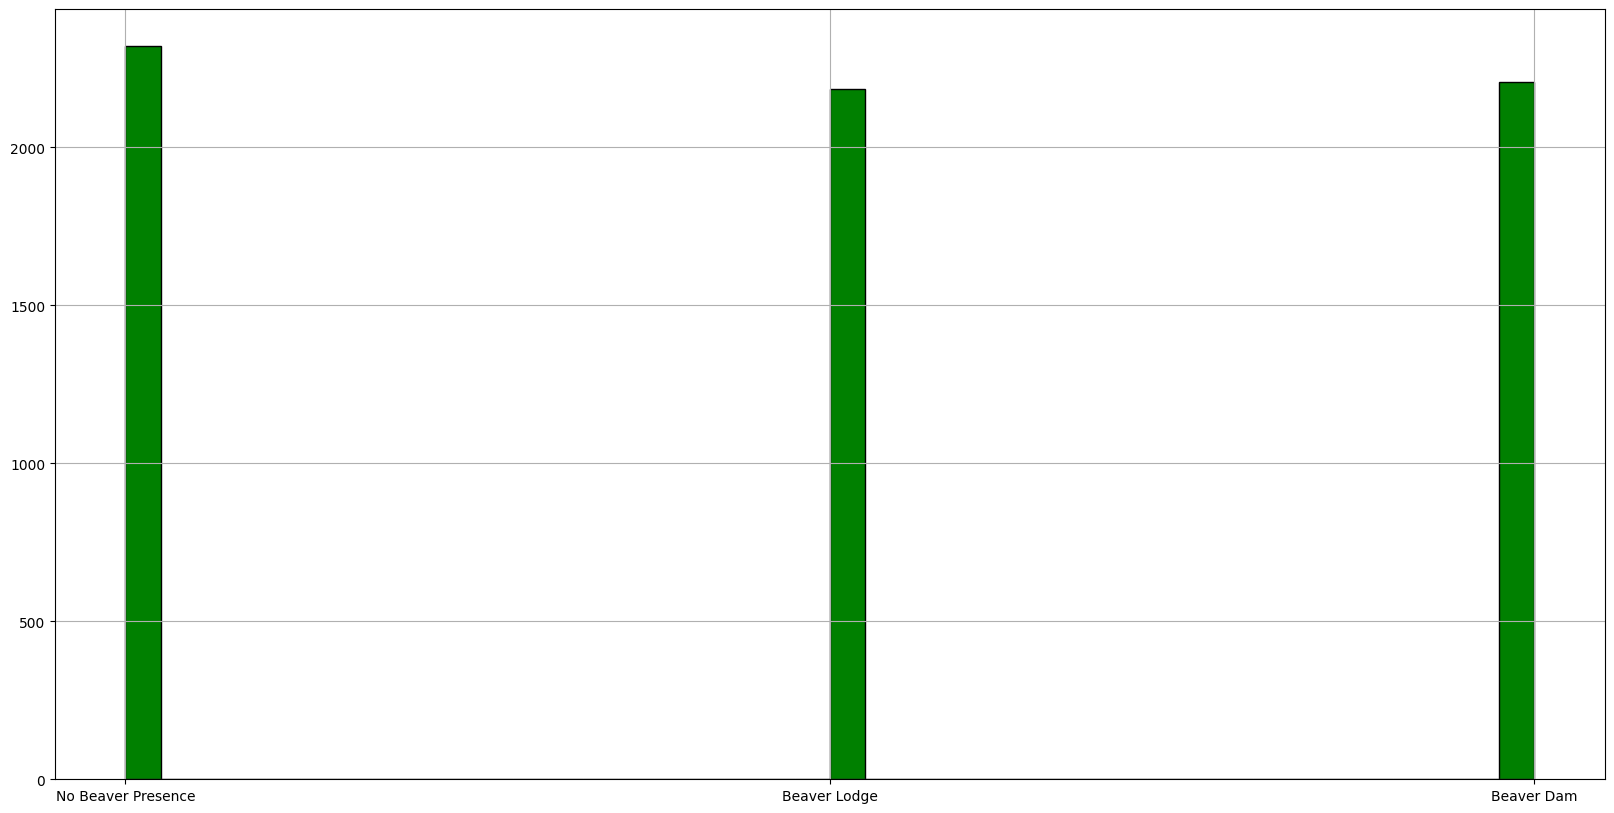

In [ ]:
getDistinctCount(dInpData_Expanded, "Simply_Beavers")

In [ ]:
 # from above its evident that we managed to create a nicely balanced data set with a decent total count of 6713 so we are good to go

In [ ]:
dInpData_Expanded.tail() 

Image_ID                           Class Simply_Beavers Image_Path  \
6708  3584_RCC90  {beaver_lodges, water, shrubs}   Beaver Lodge         NA   
6709   3584_RC90  {beaver_lodges, water, shrubs}   Beaver Lodge         NA   
6710   3584_R180  {beaver_lodges, water, shrubs}   Beaver Lodge         NA   
6711     3584_FV  {beaver_lodges, water, shrubs}   Beaver Lodge         NA   
6712     3584_FH  {beaver_lodges, water, shrubs}   Beaver Lodge         NA   

                                                  Image  Classification  
6708  [[[208, 209, 215], [211, 211, 218], [203, 204,...               1  
6709  [[[131, 143, 157], [135, 146, 156], [135, 145,...               1  
6710  [[[163, 172, 165], [156, 163, 157], [173, 182,...               1  
6711  [[[208, 209, 215], [211, 209, 217], [209, 211,...               1  
6712  [[[131, 143, 157], [130, 141, 156], [126, 139,...               1

**CNN Model**
(Simple CNN model)

Using Tensorflow, keras

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# above are essential when working with image processing and have been proven track in various
# research and experiments providing wuality results.


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats

tf.__version__

'2.12.0'

In [ ]:
# As only similar elements can be compared, it is important to align all the data to a single scale.
X = np.array(dInpData_Expanded['Image'].tolist())  # consider an entire data set
X = X/255 # as there are 0 to 255 colors in RGB, they need to be brought in a scale of 0 to 1 by dividing by max which is 255
y = dInpData_Expanded['Classification']
print(y)
y_cat = to_categorical(y, num_classes=3)

0       0
1       0
2       0
3       0
4       0
       ..
6708    1
6709    1
6710    1
6711    1
6712    1
Name: Classification, Length: 6713, dtype: int64



**Creating a TRAIN and TEST dataset**


In [ ]:
#splitting the train data further into train (75%) and test (25%) sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,test_size=0.25,random_state=45)

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

**DEFINE MODEL**

In [ ]:


# Model Original
num_classes=3
model_CNN= Sequential()
model_CNN.add(Conv2D(256, (3,3), activation='relu', input_shape=(128,128,3))) # inpout shape is 128 by 128
model_CNN.add(MaxPool2D(pool_size=(2,2)))
model_CNN.add(Dropout(0.3))

model_CNN.add(Conv2D(128, (3,3), activation='relu'))
model_CNN.add(MaxPool2D(pool_size=(2,2)))
model_CNN.add(Dropout(0.3))

model_CNN.add(Conv2D(64, (3,3), activation='relu'))
model_CNN.add(MaxPool2D(pool_size=(2,2)))
model_CNN.add(Dropout(0.3))

model_CNN.add(Flatten()) # convert 2 D array into a 1 D array
model_CNN.add(Dense(64))
model_CNN.add(Dense(3,activation='softmax')) # outout classes are 3 so output is 3
model_CNN.summary()

model_CNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 128)       0

**TRAINING THE MODEL**



In [ ]:
model_CNN.fit(X_train, y_train, epochs=EPOCH) #Model training

Epoch 1/500
158/158 [==============================] - 32s 109ms/step - loss: 1.0668 - acc: 0.5135
Epoch 2/500
158/158 [==============================] - 16s 101ms/step - loss: 0.7690 - acc: 0.7002
Epoch 3/500
158/158 [==============================] - 15s 98ms/step - loss: 0.5145 - acc: 0.8039
Epoch 4/500
158/158 [==============================] - 15s 97ms/step - loss: 0.4052 - acc: 0.8516
Epoch 5/500
158/158 [==============================] - 15s 97ms/step - loss: 0.2709 - acc: 0.9048
Epoch 6/500
158/158 [==============================] - 15s 97ms/step - loss: 0.2358 - acc: 0.9203
Epoch 7/500
158/158 [==============================] - 15s 97ms/step - loss: 0.1806 - acc: 0.9372
Epoch 8/500
158/158 [==============================] - 15s 97ms/step - loss: 0.1699 - acc: 0.9416
Epoch 9/500
158/158 [==============================] - 15s 97ms/step - loss: 0.1538 - acc: 0.9470
Epoch 10/500
158/158 [==============================] - 15s 96ms/step - loss: 0.1380 - acc: 0.9521
Epoch 11/500
158/

**FINDING ACCURACY OF MODEL**

In [ ]:
test_loss, test_acc = model_CNN.evaluate(X_test,y_test, verbose=2)

print('\nTest accuracy:', test_acc)

53/53 - 2s - loss: 0.1144 - acc: 0.9845 - 2s/epoch - 31ms/step

Test accuracy: 0.984514594078064


In [ ]:
# This is really amusing as we tried different runs that included wrongly classified labels initially as beaver dams and lodges when 
# creating meta data from masks and the model was 75% accurate.
# With minor corrections and balancingthe database, the model seem to have outperformed our expecations.

**USING MODEL TO PERFORM PREDICTIONS ON TEST DATA**

In [ ]:
Predictions = model_CNN.predict(X_test)

53/53 [==============================] - 2s 32ms/step


**VERIFYING THE PREDICTIONS**

In [ ]:
### Check Predictions (functions to show images and have a compare of the outcome of expected and actual values side by side)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
#  print (predicted_label)
  true_label=np.argmax(true_label)
#  print (true_label)

  if int(predicted_label == int(true_label)):
    color = 'green'
#    print (color)
  else:
    color = 'red'
#    print (color)

  plt.xlabel("{} {:2.0f}% \n({})".format('Predicted:'+class_names[predicted_label],
                                100*np.max(predictions_array),
                                'Actual:'+class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(7))
  plt.yticks([])
  true_label=np.argmax(true_label)
  thisplot = plt.bar(class_names, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

In [ ]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# Color correct predictions in Green and incorrect predictions in Red.
# this function can be either used to show first 15 cases or to view outcome of a selective case, value No to be passed in
# Selective in case of first 15, else pass the a numeric value within range of the results
# 
def ShowResults(Data_Name, Predictions, X_test, y_test, Selective):
    print ((" \033[1m \033[1m Results of first 15 cases of database: \033[95m"+ Data_Name + "\033[0m").center(140))
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 4*num_rows))
    if (Selective=="No"):
        for i in range(num_images):
          plt.subplot(num_rows, 2*num_cols, 2*i+1)
          plot_image(i, Predictions[i],y_test, X_test)
          plt.subplot(num_rows, 2*num_cols, 2*i+2)
          plt.xticks(rotation=90)
          plt.xlabel("Model")
          plot_value_array(i, Predictions[i], y_test)
    else:
          i=Selective
          plt.subplot(num_rows, 2*num_cols, 2*i+1)
          plot_image(i, Predictions[i],y_test, X_test)
          plt.subplot(num_rows, 2*num_cols, 2*i+2)
          plt.xticks(rotation=90)
          plt.xlabel("Model")
          plot_value_array(i, Predictions[i], y_test)   
    plt.tight_layout()
    plt.show()  
    


                                    Results of first 15 cases of database: CNN Input Data                                  


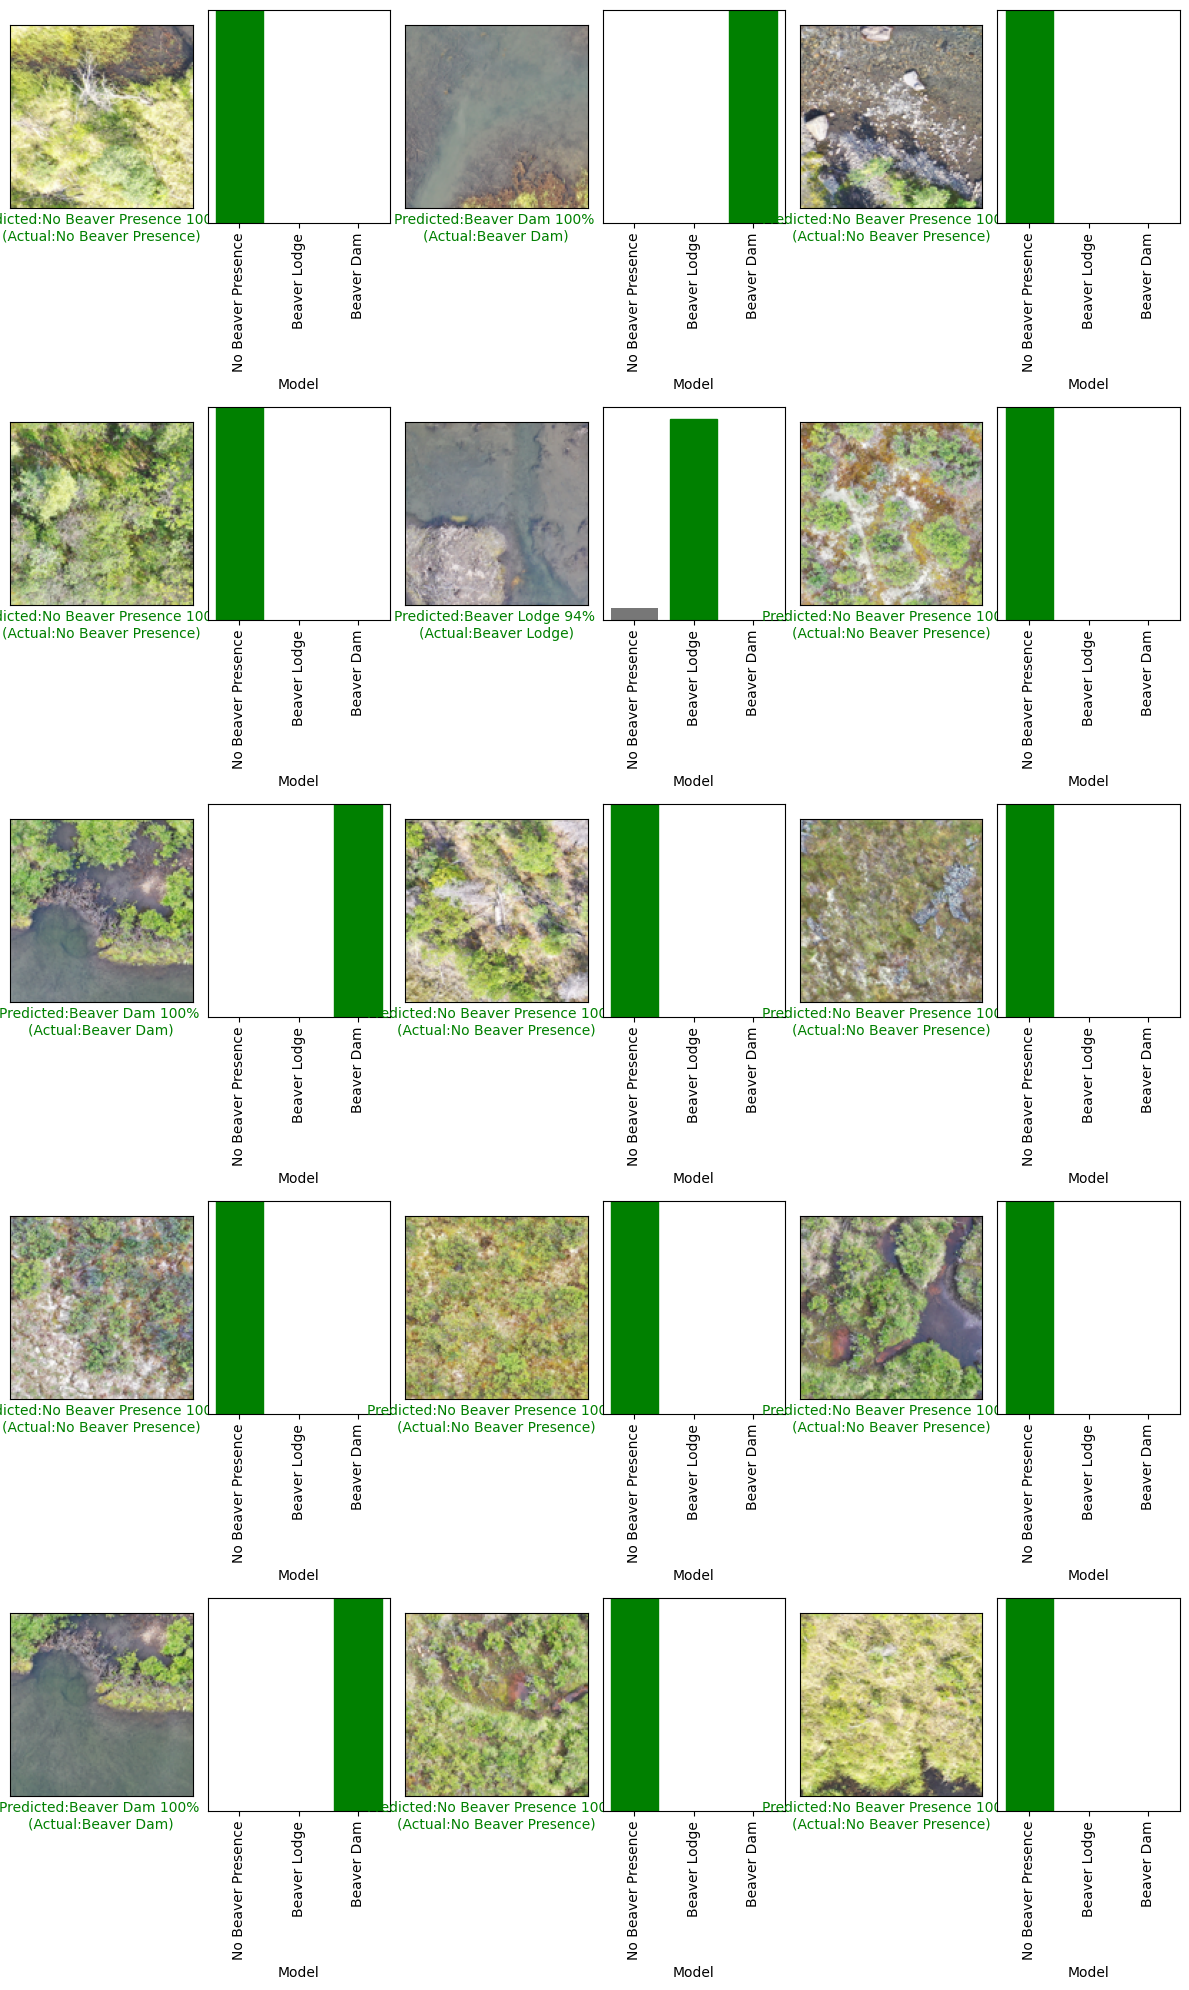

In [ ]:
ShowResults('CNN Input Data',Predictions, X_test, y_test,'No')

In [ ]:
#Observation: All green is all good :-) 
# interesting point to observe based on above plot is the bar graphs show the probability or chance it is under a particular class
# its only once case where in model was 94% sure of the class while rest cases it was 100% sure.
# the model seems to be doing really good.

**MODEL EVALUATION: CONFUSION MATRIX AND KEY SCORES**

In [ ]:
# common function to display confusion matrix 
def PlotConfusion(matrix,Label):
    confMtrx = sns.heatmap(matrix, annot=True,fmt='.0f', cmap='RdYlGn')
    confMtrx.set_title(Label+' Confusion Matrix\n');
    confMtrx.set_ylabel('Actual Values ');
    confMtrx.set_xlabel('\nPredicted Values')
    confMtrx.xaxis.set_ticklabels(class_names)
    confMtrx.yaxis.set_ticklabels(class_names)
    plt.show()
    
# as there are many models and these steps need repetation, writing a function to reduce lines of code and effort
def getErrMatrixScores(ModelName,Actual_Results,Model_Predict_result, y_test, predictions ):
    Model_ACC = metrics.accuracy_score(Actual_Results,Model_Predict_result) #Using inbuit function
    matrix = metrics.confusion_matrix(Actual_Results,Model_Predict_result) #calculating confusion matrix
    Prec_F=metrics.precision_score(Actual_Results,Model_Predict_result,  pos_label='negative', average='micro') #Precision to identify False
    Prec_T=metrics.precision_score(Actual_Results,Model_Predict_result, pos_label='positive', average='micro') #Precision to identify True
    Recall_F=metrics.recall_score(Actual_Results,Model_Predict_result, pos_label='negative', average='micro') #Recall to identify False   
    Recall_T=metrics.recall_score(Actual_Results,Model_Predict_result, pos_label='positive', average='micro') #Recall to identify True
    F1_F=metrics.f1_score(Actual_Results,Model_Predict_result, pos_label='negative',  average='micro') #F1 to identify False
    F1_T=metrics.f1_score(Actual_Results,Model_Predict_result, pos_label='positive', average='micro') #F1 to identify True
    LL = metrics.log_loss(y_test,predictions)
    print ("Model Name : "+ ModelName)
    print ("____________________________________________________________________________________________")
    print ("Accuracy Scores")
    print (Model_ACC)
    print ("____________________________________________________________________________________________")
    print ("Classification Report")
    print (metrics.classification_report(Actual_Results,Model_Predict_result, target_names=class_names)) #One command can do all the above
   
    PlotConfusion(matrix, ModelName) #plotting confusion matrix for visualisation
  #  AUC_ROC=PlotROC(ModelName, y_test ,predictions) # plot the ROC
    #print (AUC_ROC)
    AUC_ROC='NA'
    #Store the results in a outcome dataframe for a consolidate evaluation at the end
    length = len(ConsOutcome)
    values=[ModelName, Model_ACC,Prec_F, Prec_T, Recall_F, Recall_T , F1_F, F1_T, LL, AUC_ROC]
#    print (values)
    ConsOutcome.loc[length] = values 


In [ ]:
# Plots the ROC Curves One vs Rest of labels
from sklearn.datasets import load_iris
from sklearn.metrics import roc_curve, auc,roc_auc_score
from itertools import cycle

def PlotROC(ModelName,Actual_Results,Model_Predict_results):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    roc=0

#    roc=roc_auc_score(Actual_Results, Model_Predict_results, multi_class='ovr', average=None)
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(Actual_Results[:, i], Model_Predict_results[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        colors = cycle(['blue', 'red', 'green'])
# Plot of a ROC curve for a specific class
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
        label='ROC curve: '+class_names[i]+ ' (area = {1:0.2f})'.format(i, roc_auc[i]))
        roc=roc+roc_auc[i]
  #  roc=roc/7
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic: ROC :' + ModelName )
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# Prediction Balance compare function used to build data frame that has actual and predicted outcome class number
def buildCompareOutcome(y_test, predictions):
    count = len(y_test)
    dPredictCompare= pd.DataFrame(columns = ['Actual','Predicted'], )
    for i in range(count):
        length = len(dPredictCompare)
        values=[np.argmax(y_test[i]), np.argmax(predictions[i])] # the output is a chance or probabiluty of three classes and thus
        #arg max helps us get the class that was identified with highest priority which is our actual prediction
        dPredictCompare.loc[length] = values 
    return dPredictCompare
        
dPredictCompare_Orig=buildCompareOutcome(y_test, Predictions)

In [ ]:
dPredictCompare_Orig # a data set that holds the actual and predicted outcome

Actual  Predicted
0          0          0
1          2          2
2          0          0
3          0          0
4          1          1
...      ...        ...
1674       2          2
1675       1          1
1676       2          2
1677       0          0
1678       2          2

[1679 rows x 2 columns]

In [ ]:
from sklearn import metrics
ConsOutcome= pd.DataFrame(columns = ['ModelName', 'Model_ACC', 'ConF_Prec_F', 'ConF_Prec_T','Conf_Recall_F' ,'Conf_Recall_T' ,'Conf_F1_F', 'Conf_F1_T','LL' ,'Avg_AUC_ROC' ], 
                         )

# The above dataset is to capture the scores of different measures

**CONFUSION MATRIX**

Model Name : CNN
____________________________________________________________________________________________
Accuracy Scores
0.984514592019059
____________________________________________________________________________________________
Classification Report
                    precision    recall  f1-score   support

No Beaver Presence       0.99      0.96      0.98       599
      Beaver Lodge       0.98      1.00      0.99       559
        Beaver Dam       0.98      0.99      0.99       521

          accuracy                           0.98      1679
         macro avg       0.98      0.99      0.98      1679
      weighted avg       0.98      0.98      0.98      1679



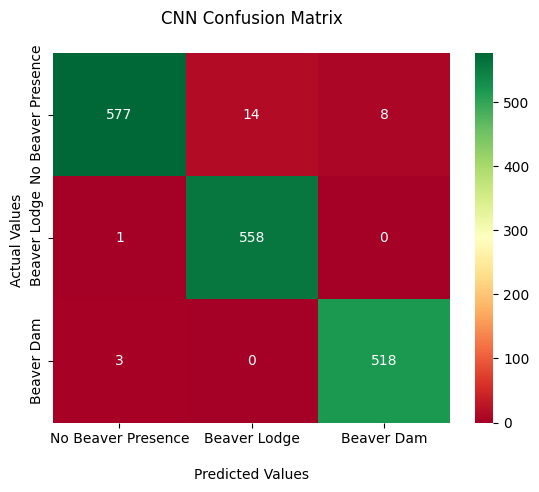

In [ ]:
getErrMatrixScores("CNN", dPredictCompare_Orig['Actual'] ,dPredictCompare_Orig['Predicted'],y_test, Predictions)

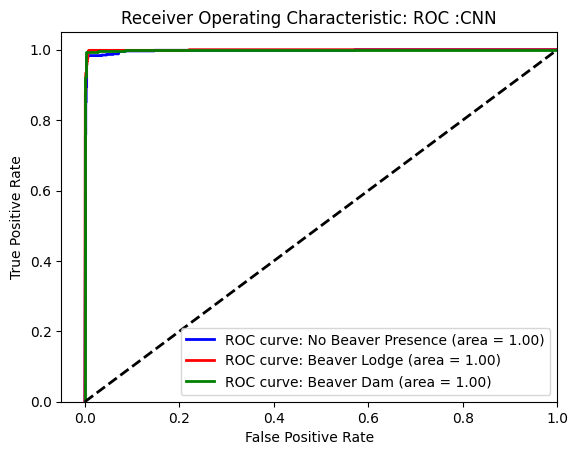

In [ ]:
PlotROC("CNN", y_test, Predictions)

**RESULT** **ANALYSIS**

**Accuracy Scores** : 0.9845 i.e. 98.45% (At a glance excellent score)

**Confusion Confusion**: While the overall score looks good, Confusion Matrix helps us understand how effective the model actually was in terms of identifying Beaver Dams (98%) and Lodges (98%) too. With precision and recall also on similar lines, the model seems to be performing well across all classes.

**Take Away**
* Starting with just a 103 images, using resizing and image augmentation technique, we managed to create a humongus data set with a count of around 6713 which was further divided into test(25%) and train(75%).

* It was evident that we did manage to boost the count of images of labels with low data count, referring to original dataset significantly, thus creating a nicely balanced data set across all classes.

FROM

No Beaver Presence    2321, 
Beaver Lodge           104, 
Beaver Dam              23, 
Total: 2448

>* Beaver Lodge: 104/2448*100 : 4.24% of total data
>* Beaver Dam: 23/2448*100 : 0.9% of total data
>* No Beaver Presence: 2321/2448*100 : 94.8% of total data

TO

No Beaver Presence    2321, 
Beaver Dam            2208, 
Beaver Lodge          2184, 
TOTAL: 6713

>* Beaver Lodge: 2184/6713*100 : 34.5% of total data
>* Beaver Dam: 2208/6713*100 : 32.89% of total data
>* No Beaver Presence  : 2321/6713*100 : 34.57% of total data


* Considering the above, the model did perform well with 500 epochs, taking around 1.5 to 2 hrs to train 

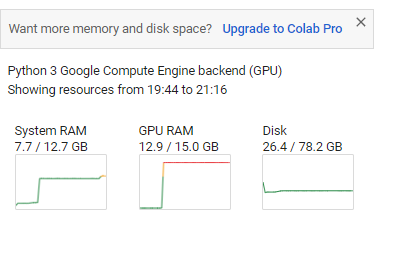

* It was clearly evident that accuracy of predicting Beaver Dams and Lodges was very high, proving our techniques of image augmentation and resizing worked wonders.

* Overall: The model showed an outstanding performance than expected and it did succeed in identifying Beaver habitat with almost 98% accuracy.

* As the source of images are from same drone and mostly cover same terrain,  it will be interesting to see how the model performs with drone images of a different area taken under different light conditions.

**Limitations**
* The model worked well when we mapped one image to one label, but what about one image with multiple labels?
* While the model identified images with Beaver dam or Lodge with high accuracy, where are these habitats on a particular image? We still need human eyes to search for the exact presence.

**Way Ahead**
* While we can say "Experiment I" did manage to run a simple CNN and achieve our mission to a certain extent, there has to be a better way to overcome the above limitations.
* Mask Region based CNN, could be the key and thus we further move to Experiment II which will attempt to achieve the same.

